In [1]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import torch
import wandb

from pit import *

In [2]:
%matplotlib widget

In [3]:
hyperparams = {
    "embedding_dim": 8,
    "hiddens": 32,
    "output_dim": 512,
    "patience": 100,
    "repeats": 10,
    "samples": 1024}

In [4]:
data = generate_data(hyperparams["repeats"], hyperparams["samples"])
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=86)
len(train_data)

640

In [46]:
BINS = 20

i, j = 0, 1
p = torch.stack([data[i][0], data[i][0]])
q = torch.stack([data[j][0], data[j][0]])
q

tensor([[0.8322, 0.8082, 0.2139,  ..., 0.3136, 0.0593, 0.6955],
        [0.8322, 0.8082, 0.2139,  ..., 0.3136, 0.0593, 0.6955]])

In [47]:
p_hist = torch.histc(p, bins=BINS, min=0, max=1) / len(p)
q_hist = torch.histc(q, bins=BINS, min=0, max=1) / len(q)
q_hist

tensor([57., 78., 54., 47., 55., 47., 55., 60., 53., 51., 53., 47., 45., 52.,
        37., 49., 43., 43., 53., 45.])

In [ ]:
-(p_hist * q_hist).sqrt().sum()

In [32]:
torch.histogram(p, BINS, range=(0, 1), density=True)[0]

tensor([0.8984, 1.2109, 0.8984, 0.7617, 0.8594, 0.8984, 1.0938, 0.9766, 0.8398,
        1.1719, 1.3867, 0.6445, 1.0938, 1.1523, 0.7227, 1.0937, 0.9961, 1.1133,
        1.0156, 1.1719])

In [ ]:
def bhattacharyya(p, q):
    

In [5]:
model = Model(
    len(train_data),
    hyperparams["embedding_dim"],
    hyperparams["hiddens"],
    hyperparams["output_dim"])
model.load_state_dict(torch.load("models/summer-sweep-31.pt"))
model

Model(
  (embedder): Embedding(640, 8)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=512, bias=True)
    (3): Sigmoid()
  )
)

In [6]:
#with wandb.init(config=hyperparams) as run:
#    config = wandb.config
#    train_epochs(model, config, train_set, validation_set)
#    torch.save(model.state_dict(), MODELPATH.format(run.name))

In [7]:
train_embeddings = model.embed(torch.arange(len(train_data), device=DEVICE))
train_embeddings.shape

torch.Size([640, 8])

In [8]:
tree = KDTree(train_embeddings, leaf_size=2, metric="euclidean")

In [19]:
test_data = [(pit(Normal(10, 1), Normal(10, 1).sample(1000)), Annotation(0, 0, 0, 0, 0, 0))]
test_set = PITDataset(test_data)
clone = model.freeze_decoder(len(test_set))
test_hyperparams = {"lr": 1e-1, "patience": 100, "bs": 1}
train_early_stopping(clone, test_hyperparams, test_set)
test_embedding = clone.embed(torch.arange(1, device=DEVICE))
test_embedding

tensor([[ 2.9905, -0.2326,  0.6691,  4.1138, -0.8404,  3.3041,  1.7948, -0.1707]])

In [20]:
def pit_hist(ax, pit_values, **kwargs):
    ax.hist(pit_values, range=(0, 1), bins=20, **kwargs)

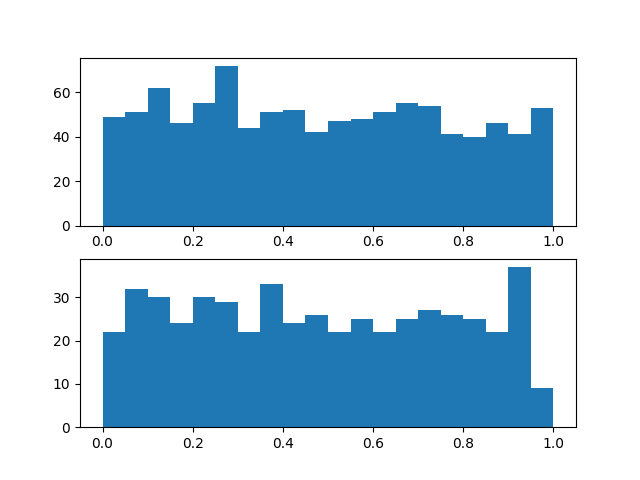

In [21]:
_, (ax1, ax2) = plt.subplots(nrows=2)
pit_hist(ax1, test_data[0][0])
pit_hist(ax2, model.decode(test_embedding[0].to(DEVICE)))

In [22]:
js = tree.query(test_embedding, k=3, return_distance=False)[0]
[train_data[j][1] for j in js]

[Annotation(weights=tensor([1., 0.]), locs=tensor([-1.,  0.]), scales=tensor([2., 1.]), pis=tensor([0.5000, 0.5000]), mus=tensor([-1.,  1.]), sigmas=tensor([1., 1.])),
 Annotation(weights=tensor([1., 0.]), locs=tensor([0., 0.]), scales=tensor([1., 1.]), pis=tensor([1., 0.]), mus=tensor([0., 0.]), sigmas=tensor([1., 1.])),
 Annotation(weights=tensor([1., 0.]), locs=tensor([0., 0.]), scales=tensor([2., 1.]), pis=tensor([0.5000, 0.5000]), mus=tensor([-2.,  2.]), sigmas=tensor([1., 1.]))]

16

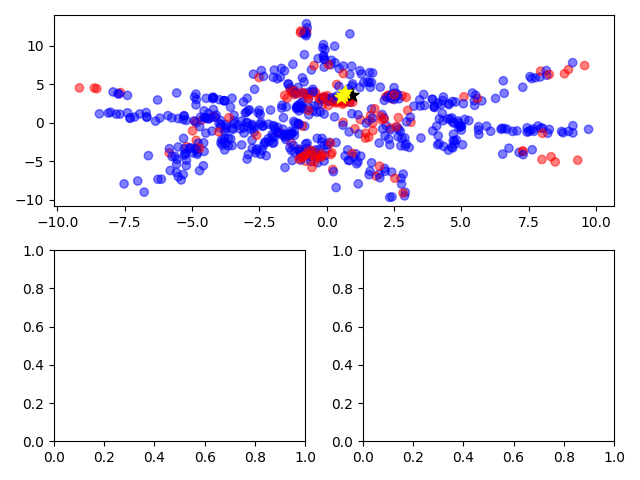

In [19]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax_true = fig.add_subplot(gs[1, 0])
ax_pred = fig.add_subplot(gs[1, 1])

ax.scatter(
    train_embeddings[:, 0], train_embeddings[:, 1],
    c=["red" if math.isclose(a.pis[0], 1.0) else "blue" for _, a in train_data],
    alpha=0.5,
    picker=True)
ax.scatter(test_embedding[:, 0], test_embedding[:, 1], marker="*", s=100, c="black")
ax.scatter(train_embeddings[js, 0], train_embeddings[js, 1], marker="*", s=100, c="yellow")

def plot_pred(event):
    x = float(event.xdata)
    y = float(event.ydata)
    if x is not None and y is not None:
        ax_pred.clear()
        pit_values = model.decode(torch.tensor([x, y]).to(DEVICE))
        pit_hist(ax_pred, pit_values, label=f"({x:.4f}, {y:.4f})")
        ax_pred.legend()
        fig.canvas.draw()

def plot_true(event):
    idx = event.ind[0]
    ax_true.clear()
    pit_values, a = train_data[idx]
    label = "\n".join(repr(a)[11:-2].split("), "))
    pit_hist(ax_true, pit_values, label=label)
    ax_true.legend()
    fig.canvas.draw()

#fig.canvas.mpl_connect("motion_notify_event", plot_pred)
fig.canvas.mpl_connect("button_press_event", plot_pred)
fig.canvas.mpl_connect("pick_event", plot_true)

In [ ]:
test_embedding

## Output true and predictive distributions

- input (PIT values)
- emedding-D
- 12-D (parameters preditive and true distribution)
    - dist_true: 2 weights (sum to 1), 2 mu, 2 sigma (positive)
    - dist_pred: 2 weights (sum to 1), 2 mu, 2 sigma (positive)
- sample from true distribution
- plug in to the CDF of predictive distribution
- PIT values -> Wasserstein distance with the true PIT values

In [ ]:
class ModelDists(Model):
    def __init__(self, n_data, embedding_dim, hiddens):
        super().__init__(n_data, embedding_dim, hiddens, 12)

    def forward(self, idx):
        output = self.decoder(self.embedder(idx))
        a = Annotation(
            output[:, :2], output[:, 2:4], output[:, 4:6],
            output[:, 6:8], output[:, 8:10], output[:, 10:])
        dists_true = [(a.pis[:, i].item(), D.Normal(a.mus[:, i], a.sigmas[:, i])) for i in [0, 1]]
        samples = torch.cat([dist.rsample((int(weight * SAMPLES), )) for weight, dist in dists_true])
        dist_pred = D.Mixture(D.Categorical(a.weights), D.Normal(a.locs, a.scales))
        return pit(pred, samples)

In [48]:
!pip freeze > requirements.txt